In [1]:
import torch
import scipy as sc
import numpy as np
from PIL import Image
import os
import re
import torch.nn.functional as F
import cv2
import numpy as np
import time
from scipy.io import loadmat, savemat
import torch.nn as nn
from tensorflow.keras.optimizers import Adam
from torch.autograd import Variable
from torchvision.models import resnet
import torchvision.transforms as transforms
from torch.utils.data import Dataset

import matplotlib.pyplot as plt

In [ ]:
folder_path = os.path.dirname(os.path.dirname(os.getcwd()))
folder_path

In [2]:
torch.cuda.empty_cache()

In [3]:
torch.cuda.empty_cache()

In [4]:
device = torch.device("cuda:0")
torch.set_default_device(device)

#torch.cuda.set_per_process_memory_fraction(0.5, device=device)

print(torch.cuda.get_device_properties(device).multi_processor_count)
torch.cuda.memory_allocated(device=torch.device("cuda"))
torch.cuda.memory_summary(device=torch.device("cuda"), abbreviated=False)

36


'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |\n|       from large pool |      0 B   |      0 B   |      0 B   |      0 B   |\n|       from small pool |      0 B   |      0 B   |      0 B   |      0 B   |\n|---------------------------------------------------------------------------|\n| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |\n|       from large pool |      0 B   |      0 B   |

In [5]:
transform = transforms.ToTensor()

In [6]:
image = Image.open(r''+folder_path+r'\Data\Test\001.jpg')

In [7]:
label = loadmat(r''+folder_path+r'\Data\Test_gt\001.mat').get('mask')
image = cv2.imread(r''+folder_path+r'\Data\Test\001.jpg')

In [8]:
image = image/255

In [9]:
np.max(image[:,:,1])

0.6666666666666666

In [10]:
label.shape

(1424, 1072)

In [11]:
bg = np.copy(label)
disk = np.copy(label)
cup = np.copy(label)

#bg[bg == 0] = 3
bg[bg == 1] = 0
bg[bg == 2] = 0
#bg[bg == 3] = 1

disk[disk == 2] = 0
cup[cup == 1] = 0
cup[cup == 2] = 1
#label[label == 2] = 255

In [12]:
label = cv2.cvtColor(label, cv2.COLOR_GRAY2RGB)

In [13]:
# label = cv2.cvtColor(label, cv2.COLOR_RGB2GRAY)

In [14]:
label[:, :, 2] = bg
label[:, :, 1] = disk
label[:, :, 0] = cup


In [15]:
label[label == 1] = 1
label[label == 2] = 1

label = Image.fromarray(label)

In [16]:
# #label = label[:, :, :2]
# label = torch.from_numpy(label)
# _, predicted_labels = torch.max(label, 2)

In [17]:
# print(predicted_labels.shape)

In [18]:
# predicted_labels[predicted_labels == 0] = 255
# predicted_labels[predicted_labels == 1] = 128
# predicted_labels[predicted_labels == 2] = 0

In [19]:
# prediction = np.copy(predicted_labels)

In [20]:
# prediction[prediction == 0] = 255
# prediction[prediction == 1] = 128
# prediction[prediction == 2] = 0

In [21]:
# label = prediction

In [22]:
#image = image.resize((512, 512), resample=Image.NEAREST)

In [23]:
# alpha = 2.0 # Contrast control (1.0 means no change)
# beta = 100   # Brightness control (0 means no change)

# adjusted_image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)

In [24]:
# cv2.imshow('Orig image', adjusted_image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

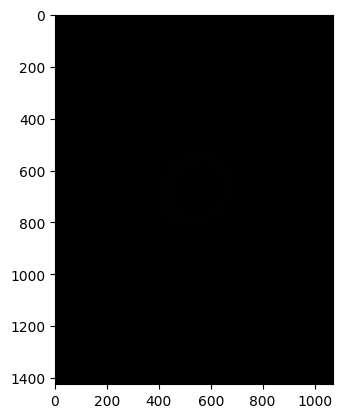

In [25]:
plt.imshow(label)

In [26]:
label[200,512]

array([0, 0, 0], dtype=uint8)

In [27]:
unique_values, counts = np.unique(label, return_counts=True)
for value, count in zip(unique_values, counts):
    print(str(value) +":    "+str(count))

0:    4515333
1:    64251


In [28]:
class CustomSegmentationDataset(Dataset):
    def __init__(self, image_paths, label_paths, transform=None):
        self.image_paths = image_paths
        self.label_paths = label_paths
        self.transform = transform
    
    def __len__(self):
        return len(os.listdir(self.image_paths))
        
    def __getitem__(self, idx):
        image_path = os.listdir(self.image_paths)[idx]
        label_path = os.listdir(self.label_paths)[idx]
        
        image = cv2.imread(self.image_paths + "\/" + image_path)
        #image = image.convert('L')
        alpha = 2.0 # Contrast control (1.0 means no change)
        beta = 100   # Brightness control (0 means no change)
        
        image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)

        
        label = loadmat(self.label_paths + "\/" +label_path).get('mask')
        bg = np.copy(label)
        disk = np.copy(label)
        cup = np.copy(label)

        bg[bg == 0] = 3
        bg[bg == 1] = 0
        bg[bg == 2] = 0
        bg[bg == 3] = 1
        
        disk[disk == 2] = 0
        cup[cup == 1] = 0
        cup[cup == 2] = 1
        
        label = cv2.cvtColor(label, cv2.COLOR_GRAY2RGB)

        label[:, :, 0] = bg
        label[:, :, 1] = disk
        label[:, :, 2] = cup
        
        if self.transform:
            image = Image.fromarray(image) 
            image = self.transform(image)#.to(device)
            image = image/255
            
            label = Image.fromarray(label)
            label = self.transform(label)
            #label = label/255
            
            label = label.to(torch.float)
        
        return image, label

In [29]:
data_transform = transforms.Compose([
    #transform.Lambda(to_grayscale_pil),
    transforms.Resize((256, 256), antialias=True),
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomVerticalFlip(),
    # transforms.RandomRotation(degrees=45),
    transforms.ToTensor(),
])

In [30]:
train_dataset = CustomSegmentationDataset(r''+folder_path+r'\Data\ImagesCroppedAugmented\Train', r''+folder_path+r'\Data\LabelsCroppedAugmented\Train', data_transform)
valid_dataset = CustomSegmentationDataset(r''+folder_path+r'\Data\ImagesCroppedAugmented\Valid', r''+folder_path+r'\Data\LabelsCroppedAugmented\Valid', data_transform)

In [31]:
batchSize = 64
train_data = torch.utils.data.DataLoader(train_dataset, batch_size=batchSize, shuffle=True, generator=torch.Generator(device='cuda'), num_workers=0, 
    pin_memory=True)
valid_data = torch.utils.data.DataLoader(valid_dataset, batch_size=batchSize, shuffle=True, generator=torch.Generator(device='cuda'), num_workers=0, 
    pin_memory=True)

In [32]:
class BasicBlock(nn.Module):

    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0, groups=1, bias=False, dropout_rate = 0.0):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size, stride, padding, groups=groups, bias=bias)
        self.bn1 = nn.BatchNorm2d(out_planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size, 1, padding, groups=groups, bias=bias)
        self.bn2 = nn.BatchNorm2d(out_planes)
        self.dropout = nn.Dropout2d(dropout_rate)
        self.downsample = None
        if stride > 1:
            self.downsample = nn.Sequential(nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False),
                            nn.BatchNorm2d(out_planes),)

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)
        out = self.dropout(out)
        return out

In [33]:
class Encoder(nn.Module):

    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0, groups=1, bias=False, dropout_rate = 0):
        super(Encoder, self).__init__()
        self.block1 = BasicBlock(in_planes, out_planes, kernel_size, stride, padding, groups, bias, dropout_rate)
        self.block2 = BasicBlock(out_planes, out_planes, kernel_size, 1, padding, groups, bias, dropout_rate)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)

        return x


In [34]:
class Decoder(nn.Module):

    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0, output_padding=0, groups=1, bias=False):
        # TODO bias=True
        super(Decoder, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(in_planes, in_planes//4, 1, 1, 0, bias=bias),
                                nn.BatchNorm2d(in_planes//4),
                                nn.ReLU(inplace=True),)
        self.tp_conv = nn.Sequential(nn.ConvTranspose2d(in_planes//4, in_planes//4, kernel_size, stride, padding, output_padding, bias=bias),
                                nn.BatchNorm2d(in_planes//4),
                                nn.ReLU(inplace=True),)
        self.conv2 = nn.Sequential(nn.Conv2d(in_planes//4, out_planes, 1, 1, 0, bias=bias),
                                nn.BatchNorm2d(out_planes),
                                nn.ReLU(inplace=True),)

    def forward(self, x):
        x = self.conv1(x)
        x = self.tp_conv(x)
        x = self.conv2(x)

        return x

In [35]:
class LinkNetBase(nn.Module):
    """
    Generate model architecture
    """

    def __init__(self, n_classes=3, num_channels = 3):
        """
        Model initialization
        :param x_n: number of input neurons
        :type x_n: int
        """
        super(LinkNetBase, self).__init__()
        self.conv1 = nn.Conv2d(num_channels, 64, 7, 2, 3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(3, 2, 1)
        
        self.encoder1 = Encoder(64, 64, 3, 1, 1)
        self.encoder2 = Encoder(64, 128, 3, 2, 1)
        self.encoder3 = Encoder(128, 256, 3, 2, 1)
        #self.encoder3 = Encoder(128, 256, 3, 2, 1, 1, False, 0.1)
        self.encoder4 = Encoder(256, 512, 3, 2, 1)
        self.encoder5 = Encoder(512, 1024, 3, 2, 1)
        #self.encoder5 = Encoder(512, 1024, 3, 2, 1, 1, False, 0.5)
        
        self.decoder1 = Decoder(64, 64, 3, 1, 1, 0)
        self.decoder2 = Decoder(128, 64, 3, 2, 1, 1)
        self.decoder3 = Decoder(256, 128, 3, 2, 1, 1)
        self.decoder4 = Decoder(512, 256, 3, 2, 1, 1)
        self.decoder5 = Decoder(1024, 512, 3, 2, 1, 1)

        # Classifier
        self.tp_conv1 = nn.Sequential(nn.ConvTranspose2d(64, 32, 3, 2, 1, 1),
                                      nn.BatchNorm2d(32),
                                      nn.ReLU(inplace=True),)
        self.conv2 = nn.Sequential(nn.Conv2d(32, 32, 3, 1, 1),
                                nn.BatchNorm2d(32),
                                nn.ReLU(inplace=True),)
        self.tp_conv2 = nn.ConvTranspose2d(32, n_classes, 2, 2, 0)
        
        self.conv3 =  nn.Sequential(nn.Conv2d(16, 16, 2, 2, 0),
                                nn.BatchNorm2d(16),
                                nn.ReLU(inplace=True),)
        self.tp_conv3 = nn.ConvTranspose2d(16, n_classes, 2, 2, 0)

        
        self.lsm = nn.LogSoftmax(dim=1) #Sigmoid/SoftMax
        self.sigm = nn.Sigmoid()
        self.sftmax = nn.Softmax(dim=1)
    
    # def conv_to_match_channels(self, input_tensor, target_tensor):
    #     # Apply a convolution to match the number of channels in input_tensor with target_tensor
    #     num_channels_input = input_tensor.shape[1]
    #     num_channels_target = target_tensor.shape[1]
    
    #     if num_channels_input < num_channels_target:
    #         # Apply a convolution to increase the number of channels
    #         conv_layer = nn.Conv2d(num_channels_input, num_channels_target, kernel_size=1, padding=0)
    #     elif num_channels_input > num_channels_target:
    #         # Apply a convolution to decrease the number of channels
    #         conv_layer = nn.Conv2d(num_channels_input, num_channels_target, kernel_size=1, padding=0)
    #     else:
    #         # No need to change channels
    #         return input_tensor
    
    #     return F.relu(conv_layer(input_tensor))
            
    def forward(self, x):
        # Initial block
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        # Encoder blocks
        e1 = self.encoder1(x)
        e2 = self.encoder2(e1)
        e3 = self.encoder3(e2)
        e4 = self.encoder4(e3)
        #e5 = self.encoder5(e4)
        
        # Decoder blocks
        d4 = e3 + self.decoder4(e4)
        #d5 = e4 + self.decoder5(e5)
        #d4 = e3 + self.decoder4(d5)
        d3 = e2 + self.decoder3(d4)
        d2 = e1 + self.decoder2(d3)
        d1 = x + self.decoder1(d2)

        # Classifier
        y = self.tp_conv1(d1)
        y = self.conv2(y)
        y = self.tp_conv2(y)
        #y = self.conv3(y)
        #y = self.tp_conv3(y)
        y = self.sftmax(y)
        
        return y

In [36]:
def get_IoU(output, target):
    # Assuming output and target are torch tensors with values of 0 or 1
    output = output.detach().cpu().numpy()
    target = target.detach().cpu().numpy()
    print(output.shape)
    
    output = torch.from_numpy(output)
    
    _, predicted_labels = torch.max(output, 1)
    _, gt_labels = torch.max(target, 2)
    
    predicted_labels_np = np.copy(predicted_labels)
    gt_labels_np = np.copy(gt_labels)
    
    predicted_labels_np[predicted_labels_np == 0] = 255
    predicted_labels_np[predicted_labels_np == 1] = 128
    predicted_labels_np[predicted_labels_np == 2] = 0

    gt_labels_np[gt_labels_np == 0] = 255
    gt_labels_np[gt_labels_np == 1] = 128
    gt_labels_np[gt_labels_np == 2] = 0

    output = predicted_labels_np
    target = gt_labels_np

    
    output = output.numel()
    target = target.numel()
    
    intersection = ((output == target) & (target != 0)).sum().item()
    union = ((output !=0) | (target != 0)).sum().item()

    iou = intersection / union if union != 0 else 0.0
    return iou

In [37]:
def get_accuracy(output, target):
    # Assuming output and target are torch tensors with values of 0 or 1
    output = output.detach().cpu().numpy()
    target = target.detach().cpu().numpy()
    print(output.shape)
    
    output = torch.from_numpy(output)
    
    _, predicted_labels = torch.max(output, 1)
    _, gt_labels = torch.max(target, 2)
    
    predicted_labels_np = np.copy(predicted_labels)
    gt_labels_np = np.copy(gt_labels)
    
    predicted_labels_np[predicted_labels_np == 0] = 255
    predicted_labels_np[predicted_labels_np == 1] = 128
    predicted_labels_np[predicted_labels_np == 2] = 0

    gt_labels_np[gt_labels_np == 0] = 255
    gt_labels_np[gt_labels_np == 1] = 128
    gt_labels_np[gt_labels_np == 2] = 0

    output = predicted_labels_np
    target = gt_labels_np
    
    output = output.numel()
    target = target.numel()
    
    correct_pixels = torch.eq(output, target).sum().item()

    accuracy = correct_pixels / total_pixels
    return accuracy

In [38]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=0.2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = (1 - pt) ** self.gamma * ce_loss

        if self.alpha is not None:
            targets = targets.argmax(dim=1)
            print(targets.shape)
            alpha_targets = targets.long()
            focal_loss = self.alpha[alpha_targets] * focal_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        elif self.reduction == 'none':
            return focal_loss
        else:
            raise ValueError("Invalid reduction option. Use 'mean', 'sum', or 'none'.")

In [39]:
num_epochs = 50
best_val_loss = float('inf')
early_stop_patience = 3
learning_rate = 0.001
weight_decay = 0.0001

In [40]:
model = LinkNetBase()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay) 
criterion = torch.nn.BCELoss()
#criterion = nn.BCEWithLogitsLoss()
#criterion = FocalLoss(2, [0.6, 0.55, 0.5])
criterion = nn.CrossEntropyLoss()#(weight=torch.tensor([0.65, 0.5, 0.55]))
#criterion = DiceBCELoss()
print(model)

LinkNetBase(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (encoder1): Encoder(
    (block1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout2d(p=0, inplace=False)
    )
    (block2): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, 

In [41]:
train_loss_list = []
valid_loss_list = [] 
total_accuracy = 0.0
total_iou = 0.0
total_samples = 0
success_epoch = 0
clip_value = 1

for epoch in range(num_epochs): 
    start_time = time.time()
    print(f'Epoch {epoch+1}/{num_epochs}:', end = ' ')
    
    success_epoch+=1
    train_loss = 0
    valid_loss = 0
    #Iterating over the training dataset in batches 
    model.train() 
    for images, labels in train_data: 
        #Extracting images and target labels for the batch being iterated 
        images = images.to(device) 
        labels= labels.to(device) 
        #Calculating the model output and the cross entropy loss 
        outputs = model.forward(images) 
        
        loss = criterion(outputs, labels) 
        #Updating weights according to calculated loss 
        optimizer.zero_grad() 
        loss.backward() 
        #torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
        optimizer.step() 
        
        # l1_loss = 0
        # l2_loss = 0
        # for name, param in model.named_parameters():
        #     if 'weight' in name:
        #         l1_loss += torch.sum(torch.abs(param))
        #         l2_loss += torch.sum(torch.pow(param, 2))
        # loss += 1e-5 * (l1_loss + l2_loss)
        
        train_loss += loss.item() 
        
        #outputs = (outputs > 0.5).float()
        
    #     batch_iou = get_IoU(outputs, labels)
    #     total_iou += batch_iou

    #     batch_accuracy = get_accuracy(outputs, labels)
    #     total_accuracy += batch_accuracy
        
    #     total_samples += images.size(0)
            
    # average_iou_train = total_iou / total_samples
    # average_accuracy_train = total_accuracy / total_samples
    
    model.eval()
    with torch.no_grad():
        for i, (images, labels) in enumerate(valid_data):
            images = images.to(device) 
            labels = labels.to(device)
            
            outputs = model(images) 
            loss = criterion(outputs, labels)
            
            l1_loss = 0
            l2_loss = 0
            for name, param in model.named_parameters():
                if 'weight' in name:
                    l1_loss += torch.sum(torch.abs(param))
                    l2_loss += torch.sum(torch.pow(param, 2))
            loss += 1e-5 * (l1_loss + l2_loss)
                
            valid_loss += loss.item() 
            
    
    if valid_loss < best_val_loss:
        best_val_loss = valid_loss
        current_patience = 0
    else:
        current_patience += 1
        if current_patience >= early_stop_patience:
            break
    #Printing loss for each epoch 
    train_loss_list.append(train_loss/len(train_data))
    valid_loss_list.append(valid_loss/len(valid_data)) 
    print(f"Time:{time.time() - start_time} sec   Training loss = {train_loss_list[-1]} Validation loss = {valid_loss_list[-1]}")# IoU_train = {average_iou_train}  Iou_valid = {average_iou_valid} Accuracy_train = {average_accuracy_train} Accuracy_valid = {average_accuracy_valid}") #  DICE: {dice_coef}")      

Epoch 1/50: Time:121.7868242263794 sec   Training loss = 0.003600697164074518 Validation loss = 0.0039052114298101515
Epoch 2/50: Time:96.27143001556396 sec   Training loss = 0.0032020467697293498 Validation loss = 0.003604498051572591
Epoch 3/50: Time:95.82412600517273 sec   Training loss = 0.0030618586388300173 Validation loss = 0.003137552092084661
Epoch 4/50: Time:90.32511806488037 sec   Training loss = 0.003008214152941946 Validation loss = 0.0056543893297202885
Epoch 5/50: Time:93.1335723400116 sec   Training loss = 0.0029732110488112085 Validation loss = 0.0031783728627488017
Epoch 6/50: Time:101.24652457237244 sec   Training loss = 0.0029563656280515715 Validation loss = 0.002956542040919885
Epoch 7/50: Time:98.39109897613525 sec   Training loss = 0.0029245520927361213 Validation loss = 0.002999510004883632
Epoch 8/50: Time:103.20879244804382 sec   Training loss = 0.002934638316219207 Validation loss = 0.0032373308204114437
Epoch 9/50: 

In [42]:
# images = images.to('cpu')
# plt.imshow(images[3, 1, :, :])

In [43]:
# labels = labels.to('cpu')
# plt.imshow(labels[3, 0, :, :])

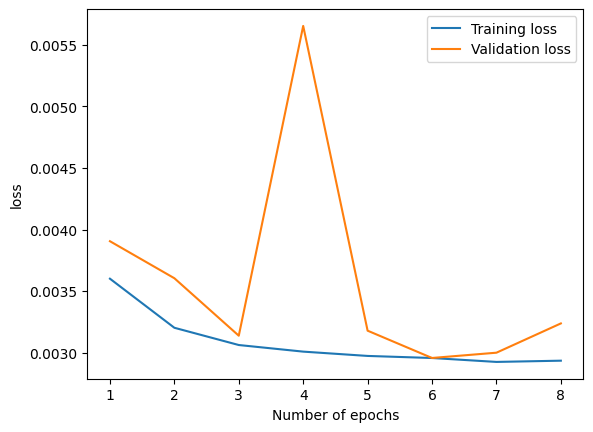

In [45]:
plt.plot(range(1,success_epoch), train_loss_list, label="Training loss") 
plt.plot(range(1,success_epoch), valid_loss_list, label="Validation loss") 
plt.xlabel("Number of epochs") 
plt.ylabel("loss") 
plt.legend()

In [46]:
folder = r''+folder_path+r'\Data'

test_folder = folder + '\Test'
test_gt_folder = folder + '\Test_gt'
test_results_folder = folder + '\Test_results'
test_results_disk_folder = folder + '\Test_results_disk'
test_results_cup_folder = folder + '\Test_results_cup'

test_files = os.listdir(test_folder)
test_gt_files = os.listdir(test_gt_folder)

In [47]:
images_test = []
for file in test_files:
    images_test.append(test_folder + "\/" + file)

In [48]:
images_test_gt = []
for file in test_gt_files:
    images_test_gt.append(test_gt_folder + "\/" + file)

In [49]:
transform

ToTensor()

(3, 512, 512)
(512, 512)


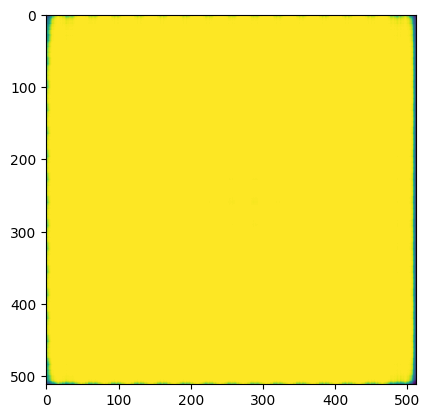

In [54]:
threshold = 0.5
model.eval()
with torch.no_grad():
    for image in images_test:
        filename = os.path.basename(image)
        #cropped_image = crop_image(np.array(Image.open(image)), 20, 40)
        #image = Image.fromarray(cropped_image)
        image = Image.open(image)
        orig_image = image
        image = image.resize((512, 512), resample=Image.NEAREST)
        #image = image.convert('L')
        image = transform(image)
        image = image/255
        image = image.unsqueeze(0)

        image = image.to(device) 
        output = model(image)

        output = output.detach().cpu().numpy()[0]
        # output = (output[0, :, :])
        # output = (output - np.min(output) ) / (np.max(output) - np.min(output))
        # output = (output > threshold)
        #output = (output[0, :, :] > threshold)
    
        # output = torch.stack(output).sum(dim=1) > 0
        # output = output.detach().cpu().numpy()[0]

        # output[0, :, :] = (output[0, :, :] - np.min(output[0, :, :])) / (np.max(output[0, :, :]) - np.min(output[0, :, :]))*255
        # output[1, :, :] = (output[1, :, :] - np.min(output[1, :, :])) / (np.max(output[1, :, :]) - np.min(output[1, :, :]))*255
        # output[2, :, :] = (output[2, :, :] - np.min(output[2, :, :])) / (np.max(output[2, :, :]) - np.min(output[2, :, :]))*255

        #bg = np.copy(output[0, :, :])
        # disk = np.copy(output[0, :, :])
        # cup = np.copy(output[1, :, :])

        # bg[bg > threshold] = 0
        # disk[disk> threshold] = 255
        # disk[disk<threshold] = 0
        #disk[disk < threshold] = 0
        # cup[cup > threshold] = 1
        # cup[cup < threshold] = 0

        # output[0, :, :] = bg
        # output[0, :, :] = disk
        # output[1, :, :] = cup
        
        # output = np.transpose(output, (1, 2, 0))
        # output = cv2.cvtColor(output, cv2.COLOR_RGB2GRAY)
        print(output.shape)
        output = np.transpose(output, (1, 2, 0))
        
        output = torch.from_numpy(output)
        
        _, predicted_labels = torch.max(output, 2)
        prediction = np.copy(predicted_labels)
       
        prediction[prediction == 0] = 0
        prediction[prediction == 1] = 128
        prediction[prediction == 2] = 255

        # prediction[prediction == 0] = 255
        # prediction[prediction == 1] = 0
        # prediction[prediction == 2] = 128
        
        plt.imshow(output[:,:,2])
        #plt.imshow(prediction)
        print(prediction.shape)
        
        break
        
        output_dict = {"mask": output}
        savemat(test_results_disk_folder + "\/" + filename.strip(".jpg") + ".mat", output_dict)

In [ ]:
plt.imshow(orig_image)

In [ ]:
unique_values, counts = np.unique(predicted_labels, return_counts=True)
for value, count in zip(unique_values, counts):
    print(str(value) +":    "+str(count))